# Introduction

Analyzing data from LabRAD should be simple. When you take a scan, LabRAD saves the data in a directory labelled by its date and its time. Thus it should be possible, given only this information, to extract the data of a scan as nice, neat x and y values. That's exactly the functionality that the module `labrad_data_tools.py` aims to provide.

There are also a few conveniences that the package offers, which this tutorial will mention. For example, you can exclude bad data points (in case, say, a laser came unlocked at the end of your scan), and you can concatenate multiple scans together to easily treat them as a single dataset.

Finding data given a date and time only works if you have a functioning `track_scans.sh` script, which indexes the save location of every LabRAD scan as the data is created in a directory called `scan_lists`. If you don't have this, then this won't work.

# Importing basic data from LabRAD

In [1]:
import labrad_data_tools as ldt
import matplotlib.pyplot as plt
import numpy as np

## The function `get_data`

The most basic function of `labrad_data_tools` is `get_data`. Pass in a date and time, and it returns the x and y values of the data for the corresponding scan in their own arrays.

In [2]:
(x, y) = ldt.get_data('20180420', '1605.26')

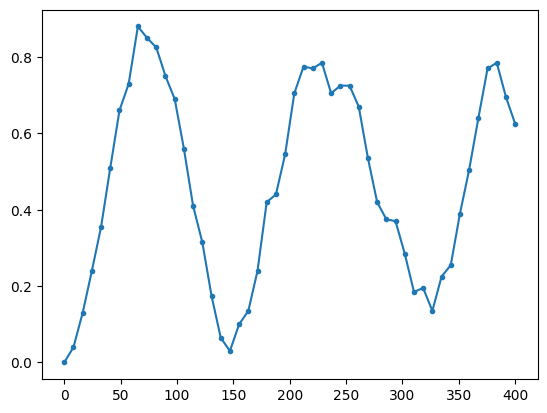

In [3]:
plt.plot(x, y, '.-')
plt.show()

You can use either a period or an underscore in the scan timestamp:

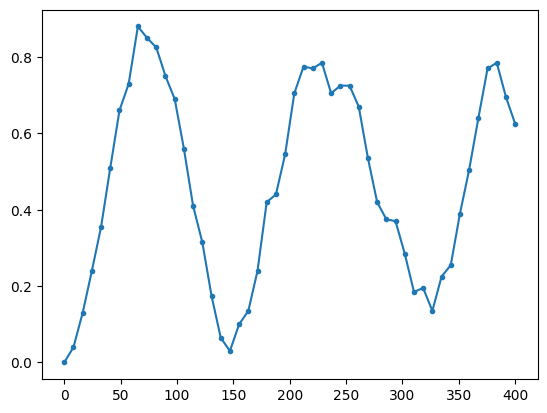

In [4]:
(x, y) = ldt.get_data('20180420', '1605_26')
plt.plot(x, y, '.-')
plt.show()

## Excluding data points

Sometimes, something goes wrong during a scan, such as a laser coming unlocked. Here is a Ramsey scan with two ions, but at the end, one ion was lost. I didn't notice until 8 one-ion data points had been taken, so there is bad data at the end of the scan.

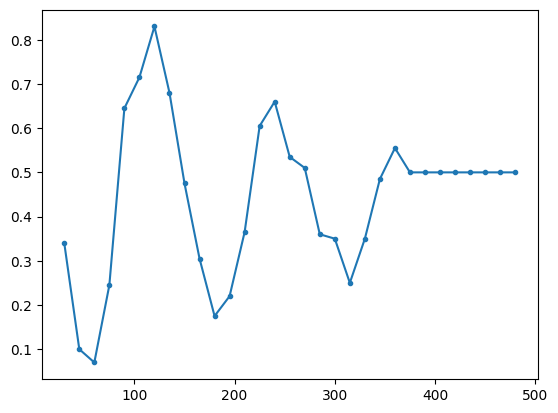

In [5]:
(x, y) = ldt.get_data('20230217', '1701.42')
plt.plot(x, y, '.-')
plt.show()

If we still want this data to be useful, for example to fit it to something, we have to remove the bad data points from both the x and y arrays. This isn't too hard to do manually, but `get_data` provides the convenience of doing this from the beginning by specifying which data points to exclude. This is done with the keyword argument `exclude`. The default value of `exclude` is the empty list: `exclude=[]`.

To exclude data points, specify a list of the indices of the data points you want to exclude. In this case, we want to exclude the final eight data points.

In [6]:
len(x)

31

There are 31 datapoints total, so we want to exclude data points 23 through 30. We can pass a list of these indices into the `exclude` keyword argument of `get_data` to exclude the bad data points.

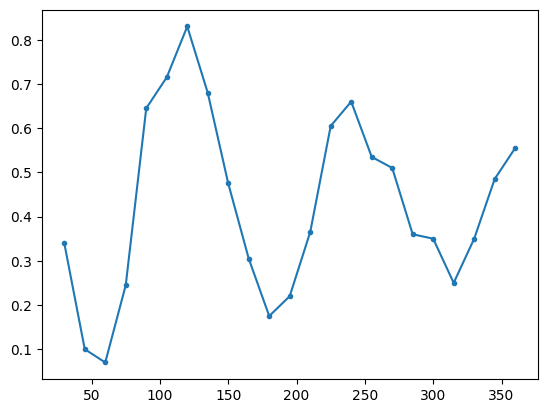

In [7]:
(x, y) = ldt.get_data('20230217', '1701.42', exclude=[23, 24, 25, 26, 27, 28, 29, 30])
plt.plot(x, y, '.-')
plt.show()

Of course, it's easier to use the python function `range` to construct a list of consecutive integers, and it works for this purpose as well:

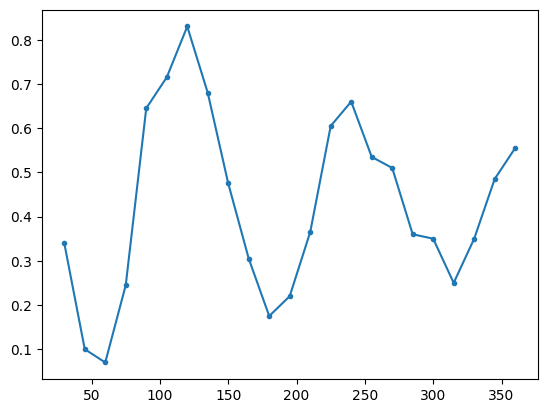

In [8]:
(x, y) = ldt.get_data('20230217', '1701.42', exclude=range(23, 31))
plt.plot(x, y, '.-')
plt.show()

In python, it's even easier to specify the indices of the last few elements of a list using negative indices. `get_data` supports using negative indices as well. We can specify that we want to exclude the final 8 data points by instead simply passing in a list of indices from -8 to -1:

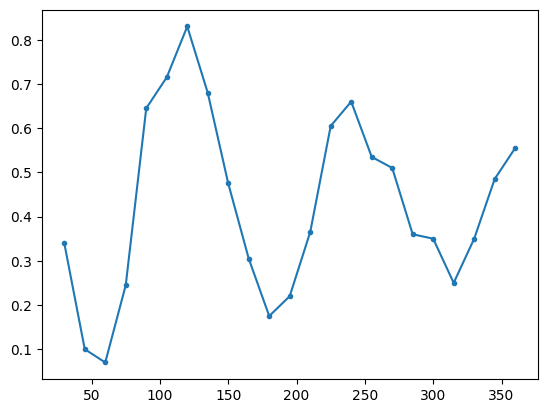

In [9]:
(x, y) = ldt.get_data('20230217', '1701.42', exclude=range(-8, 0))
plt.plot(x, y, '.-')
plt.show()

## Concatenating scans

Sometimes we want to continue a scan after it has finished, and we want to consider both/all the scans as a single dataset. Take this coherence scan for example. The coherence lasted longer than I expected, so I started a new scan to make the dataset complete. 

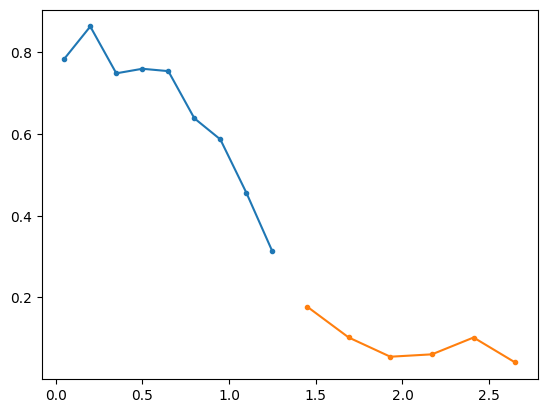

In [10]:
(x1, y1) = ldt.get_data('20230412', '2029.03')
(x2, y2) = ldt.get_data('20230412', '2040.08')

plt.plot(x1, y1, '.-')
plt.plot(x2, y2, '.-')
plt.show()

Analyzing this data is easier if we combine these together. Again, this isn't hard to do manually, but `get_data` provides the convenience of doing it automatically. To do this, we can simply pass in a list of the scantimes we want to concatenate together rather than a single scantime.

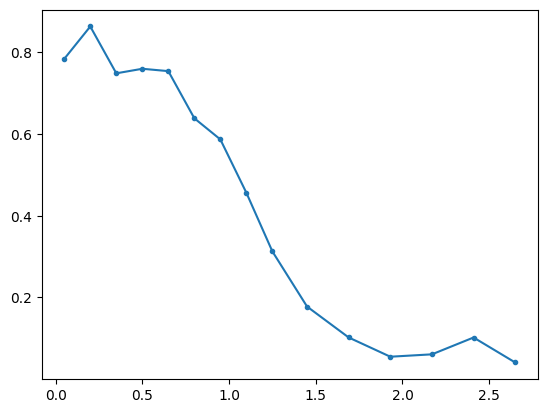

In [11]:
(x, y) = ldt.get_data('20230412', ['2029.03', '2040.08'])
plt.plot(x, y, '.-')
plt.show()

## Concatenating scans and excluding data points at the same time

Often, the reason that we do a second scan in the first place is that something went wrong, we stop the first scan, fix the problem, and then start a new scan to complete the dataset. This is the scase for the Ramsey scan for which we exlcuded data points above. There's actually a second scan to complete the dataset:

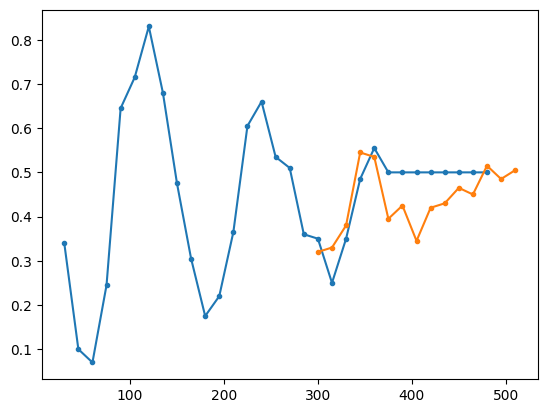

In [12]:
(x1, y1) = ldt.get_data('20230217', '1701.42')
(x2, y2) = ldt.get_data('20230217', '1715.19')

plt.plot(x1, y1, '.-')
plt.plot(x2, y2, '.-')
plt.show()

Wouldn't it be nice if we could combine these into a single pair of x and y arrays, excluding the data points that we don't want? Yep, `get_data` lets you do that.

To do this, pass in a list of scantimes as the second argument, as above. Now that we have a list of multiple scantimes, the keyword argument `exclude` expects to get a list of lists: the first list specifies which data points to exclude from the first scan, the second list specifies which to exclude from the second list, etc. We are concatenating two scans here, so exclude needs to be a list of two lists. We want to exclude the final eight points from the first scan, so we make the first list `range(-8, 0)`. We don't want to exclude any data points from the second scan, so we make the second list the empty list `[]`. Together, the value of the keyword argument `exclude` should be `[range(-8, 0), []]`.

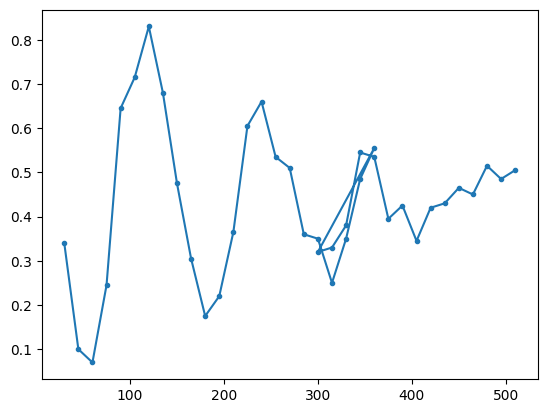

In [13]:
(x, y) = ldt.get_data('20230217', ['1701.42', '1715.19'], exclude=[range(-8, 0), []])
plt.plot(x, y, '.-')
plt.show()

Ta da! Now you can treat this like a single dataset.

# Getting raw data from 2-dimensional scans

2D scans, such as heating rates, are useful. In LabRAD, we often scan over one parameter (eg the Rabi time), have the grapher fit some value to that scan (eg nbar), then increment the other parameter (eg wait time), and repeat. When analyzing data carefully, I often want to work with the raw data myself rather than trust the grapher's fits. Wouldn't it be nice if you could get all the data from the Rabi scans that comprise a heating rate scan?

To do this, use the function `get_subscantimes(date, superscantime, exclude=[], return_xvalues=False)`. The nomenclature I'm defining here is that the meta-scan is called the "superscan", and all the 1D scans that it consists of are the "subscans". This function returns a list `subscantimes` of the subscan times, so you can use any of the above functions to get the data for these. The optional argument `exclude` works like above; feed in a list of indices, this time indicating the subscans you want to exclude. If the optional argument `return_xvalues` is `True`, then instead of just the list `subscantimes`, the function returns a tuple `(xvalues, subscantimes)`, where `xvalues` is a list of the x-values for the superscan (e.g. if the superscan is a heating rate, it returns the wait times for each subscan). So `xvalues` and `subscantimes` have the same size.

As an example, we took a heating rate of 2022-03-31 with the scantime 1111.48. This included 7 Rabi flops as subscans. Usage examples with this:

In [14]:
ldt.get_subscantimes('20220331', '1111.48')

['1110_35', '1111_49', '1113_53', '1116_48', '1120_36', '1125_15', '1130_44']

In [15]:
ldt.get_subscantimes('20220331', '1111.48', exclude=[-1])

['1110_35', '1111_49', '1113_53', '1116_48', '1120_36', '1125_15']

In [16]:
ldt.get_subscantimes('20220331', '1111.48', return_xvalues=True)

(array([ 0., 10., 20., 30., 40., 50., 60.]),
 ['1110_35', '1111_49', '1113_53', '1116_48', '1120_36', '1125_15', '1130_44'])

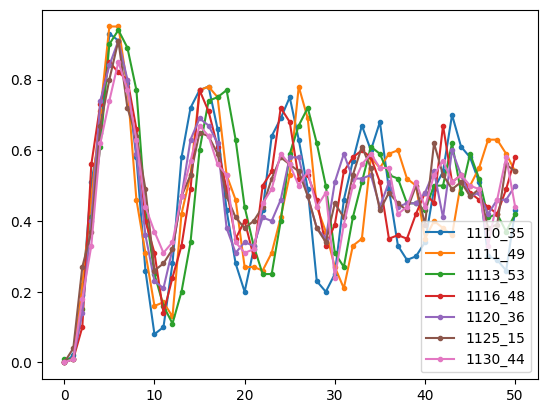

In [17]:
(fig, ax) = plt.subplots()

subscantimes = ldt.get_subscantimes('20220331', '1111.48')
for scantime in subscantimes:
    (x, y) = ldt.get_data('20220331', scantime)
    ax.plot(x, y, '.-', label=scantime)
ax.legend()

plt.show()

When combined with the fitting tools (`fitting_tools.py`), this can be a nice way to easily extract information from multi-dimensional datasets.

## How does get_subscantimes know where/how to find subscans?

`labrad_data_tools` can identify the experiment type for any given scan. For example:

In [18]:
ldt.get_experiment_name('20220331', '1111.48')

'Heating_Rate_Rabi'

In [19]:
ldt.get_experiment_name('20220331', '1110.35')

'Rabi'

To identify the subscans of a given superscan, `labrad_data_tools` needs you to define a mapping between their respective experiment names in the config file `labrad_data_tools_config.py`. This is done with an entry in the dictionary `MULTID_SCAN_MAP`. The relevant entry in the dictionary for this mapping is `'Heating_Rate_Rabi': (['Rabi'], 1, 'new')`. The `1` indicates how many subscans there are per superscan data point, and the `'new'` indicates that this mapping is for the new scripscanner (i.e. v2). More details about this in `labrad_data_tools_config.py`.

# Getting scan parameters

The function `get_parameters(date, scantime)` returns a huge dictionary of all LabRAD parameters for the scan.

In [20]:
ldt.get_parameters('20241007', '1454.21')

OrderedDict([('CalibTrapFreqs.sideband1_amplitude729', Value(-7.0, 'dBm')),
             ('CalibTrapFreqs.sideband1_channel729', '729vert'),
             ('CalibTrapFreqs.sideband1_duration729', Value(12.0, 'us')),
             ('CalibTrapFreqs.sideband1_line_selection_729', 'S-1/2D-1/2'),
             ('CalibTrapFreqs.sideband1_order', -1.0),
             ('CalibTrapFreqs.sideband1_sideband_selection',
              'radial_frequency_1'),
             ('CalibTrapFreqs.sideband2_amplitude729', Value(-7.0, 'dBm')),
             ('CalibTrapFreqs.sideband2_channel729', '729vert'),
             ('CalibTrapFreqs.sideband2_duration729', Value(12.0, 'us')),
             ('CalibTrapFreqs.sideband2_line_selection_729', 'S-1/2D-1/2'),
             ('CalibTrapFreqs.sideband2_order', -1.0),
             ('CalibTrapFreqs.sideband2_sideband_selection',
              'radial_frequency_2'),
             ('CalibVertDoppler.amplitude729', Value(-15.0, 'dBm')),
             ('CalibVertDoppler.channel729'

The key is a single string of the form `'collection.parameter'`, and the value is the parameter, which if it has units, is a LabRAD-specific unitful data type.

Usually you're just looking for one specific parameter of a collection of them. To narrow down the results, give a string as the optional parameter `search`. The returned dictionary will contain parameters whose name includes the string.

For example, if I only want to see doppler cooling parameters:

In [21]:
ldt.get_parameters('20241007', '1454.21', search='DopplerCooling')

OrderedDict([('DopplerCooling.doppler_cooling_amplitude_397',
              Value(-26.0, 'dBm')),
             ('DopplerCooling.doppler_cooling_amplitude_866',
              Value(-12.0, 'dBm')),
             ('DopplerCooling.doppler_cooling_duration', Value(6.0, 'ms')),
             ('DopplerCooling.doppler_cooling_frequency_397',
              Value(207.0, 'MHz')),
             ('DopplerCooling.doppler_cooling_frequency_866',
              Value(68.0, 'MHz')),
             ('DopplerCooling.doppler_cooling_repump_additional',
              Value(50.0, 'us'))])

Since this is a dictionary, if I want to pick out the 397 Doppler cooling frequency specifically, I can index the dictionary key `'DopplerCooling.doppler_cooling_frequency_397'`:

In [22]:
f_doppler = ldt.get_parameters('20241007', '1454.21')['DopplerCooling.doppler_cooling_frequency_397']
f_doppler

Value(207.0, 'MHz')

This is a LabRAD data type. To turn it into an ordinary number, you can index it with the units. See https://sourceforge.net/p/labrad/wiki/Units/ for more info.

In [23]:
f_doppler['MHz']

207.0

In [24]:
f_doppler['kHz']

207000.0

# Other functionality

## `get_data_manual`

For one reason or another, `track_scans.sh` might occasionally fail to index a LabRAD scan in `scan_lists`. If this happens, and you know where the data is saved but it just isn't index properly, you can extract the data with the function `get_data_manual`. This function takes a single argument, the directory where the data was saved.

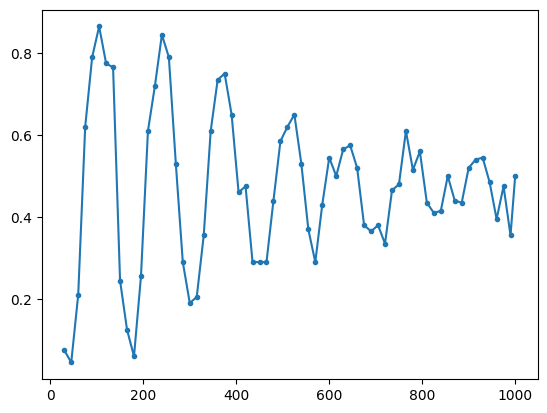

In [25]:
(x, y) = ldt.get_data_manual('/home/space-time/LabRAD/data/Experiments.dir/20230217.dir/Ramsey.dir/1511_29.dir/')

plt.plot(x, y, '.-')
plt.show()

## `get_consecutive_scantimes`

Returns the list of scantimes for a given experiment given the first one and the last one in the set you're interested in. Useful if you repeated a data set a few times and want to compare the results. Also supports excluding some scans by their index.

In [26]:
scantimes = ldt.get_consecutive_scantimes('20240801', '1741.08', '1749.12')
scantimes

['1741_08', '1743_59', '1745_17', '1746_35', '1747_53', '1749_12']

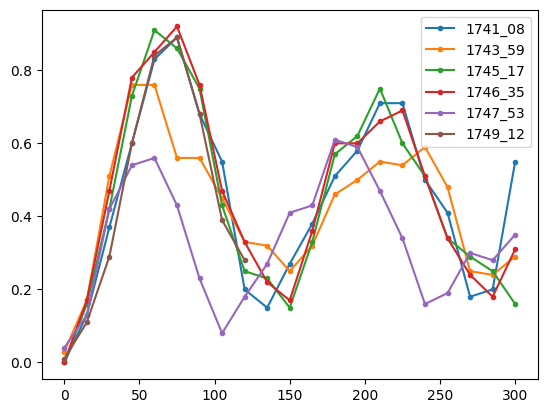

In [27]:
(fig, ax) = plt.subplots()

for scantime in scantimes:
    (x, y) = ldt.get_data('20240801', scantime)
    ax.plot(x, y, '.-', label=scantime)
ax.legend()

plt.show()

## `get_photon_counts`

If your LabRAD setup is configured to save raw photon counts in addition to the usual excitation data, it may be saved in a file which ends with `Readouts.csv`. If this is the case, then the function `get_photon_counts` returns those counts for you.

The result is a 2D array. Each row of that array corresponds to a single data point. Within each row is the list of all the photon count numbers for each repetition shot (eg 100 entries for 100 repetitions).

The x-axis data (scanned parameter values) are not returned by this function.

In [28]:
ldt.get_photon_counts('20230217', '1511_29')

array([[208., 226., 246., ..., 114., 220., 226.],
       [228., 223., 247., ..., 233., 112., 224.],
       [237., 228.,  14., ...,  11., 118., 104.],
       ...,
       [ 18., 117.,  17., ..., 213.,  15., 107.],
       [ 19., 232.,  19., ..., 242., 119., 109.],
       [123.,  12., 230., ..., 111., 209., 231.]])

For example, the 100 photon counts for the first data point can be found with

In [29]:
ldt.get_photon_counts('20230217', '1511_29')[0]

array([208., 226., 246., 202., 208., 254., 202., 227., 249., 100., 128.,
       230., 218., 132., 212., 111., 241., 237., 185., 243., 211., 226.,
       249., 235., 228., 218., 242., 208., 127.,  18., 216., 211., 132.,
       238., 224., 201., 207., 233., 232., 197., 200., 229., 125., 251.,
       201., 225., 234., 110., 217., 228., 220., 218., 200., 213., 240.,
       232., 206., 208., 203.,  15., 204., 215., 222., 222., 243., 214.,
       237., 246., 224., 239., 233., 229., 246., 215., 240., 224., 222.,
       210., 211., 205., 191., 197., 231.,  99., 224., 211., 211., 255.,
       231., 220., 232., 256., 209., 210., 213.,  93., 243., 114., 220.,
       226.])

Here there are two ions and there is a low probability of excitation so the count numbers are high.

And the photon 100 counts for the fourth data point can be found with

In [30]:
ldt.get_photon_counts('20230217', '1511_29')[3]

array([ 13.,  14., 165.,  12., 108., 205.,  16.,  17., 115., 138., 136.,
       111., 116.,  15., 135., 122., 100., 134., 126., 107., 127.,  13.,
       109., 131.,  98., 112., 215., 121., 125.,  16., 124., 109.,  18.,
        13., 122.,  82.,  11., 104., 131., 234., 124., 118.,  14., 111.,
       229., 115., 111.,  13., 128., 119.,  13.,  17., 201.,  19., 125.,
       219., 122., 126., 125.,  12., 120., 126.,   7., 112.,  17., 132.,
        15.,  22.,  18., 102.,  19.,  18., 129., 116., 105.,  13., 112.,
        18., 101.,  13.,  15.,   9., 214., 116., 122.,   9., 117.,  12.,
       109., 106.,  10., 214.,  10.,  17., 105., 116., 123., 137., 233.,
       108.])

Here the ions are more excited so the readout photon counts are lower.

## `get_raw_number_dark`

This function essentially processes the photon counts into the number of ions dark.

Returns a 2-tuple:
- The x-axis data (parameter being scanned)
- y-axis data structured as the probabilitiy to find N ions dark. For each data point, if there were N ions being read out, the y-axis data contains a list of N+1 elements for each data point. The jth element of this list is the probability that j ions were found dark (not excited).

This function infers the threshold for photon counts using whatever is stored for the parameter `StateReadout.threshold_list`. It is also possible to override this saved parameter value with the optional keyword argument `threshold_list`.

The information returned by this function can be used to construct the average excitation probability, or other observables like parity.

In [31]:
ldt.get_raw_number_dark('20230217', '1511_29')

(array([  30.,   45.,   60.,   75.,   90.,  105.,  120.,  135.,  150.,
         165.,  180.,  195.,  210.,  225.,  240.,  255.,  270.,  285.,
         300.,  315.,  330.,  345.,  360.,  375.,  390.,  405.,  420.,
         435.,  450.,  465.,  480.,  495.,  510.,  525.,  540.,  555.,
         570.,  585.,  600.,  615.,  630.,  645.,  660.,  675.,  690.,
         705.,  720.,  735.,  750.,  765.,  780.,  795.,  810.,  825.,
         840.,  855.,  870.,  885.,  900.,  915.,  930.,  945.,  960.,
         975.,  990., 1000.]),
 array([[0.87, 0.11, 0.02],
        [0.93, 0.05, 0.02],
        [0.68, 0.22, 0.1 ],
        [0.1 , 0.56, 0.34],
        [0.08, 0.26, 0.66],
        [0.06, 0.15, 0.79],
        [0.09, 0.27, 0.64],
        [0.12, 0.23, 0.65],
        [0.64, 0.23, 0.13],
        [0.79, 0.17, 0.04],
        [0.88, 0.12, 0.  ],
        [0.59, 0.31, 0.1 ],
        [0.2 , 0.38, 0.42],
        [0.13, 0.3 , 0.57],
        [0.07, 0.17, 0.76],
        [0.1 , 0.22, 0.68],
        [0.31, 0.32, 0.3

For this scan, two ions were present, so each y-value data point has 3 elements: The probability of finding 0 ions dark, 1 ion dark, and 2 ions dark.

In [32]:
ldt.get_parameters('20230217', '1511_29')['StateReadout.threshold_list']

'40,150'

The thresholds were set at 40 and 150 photons.

If we want, we can reprocess this same data with a different threshold:

In [33]:
ldt.get_raw_number_dark('20230217', '1511_29', threshold_list=[25, 115])

(array([  30.,   45.,   60.,   75.,   90.,  105.,  120.,  135.,  150.,
         165.,  180.,  195.,  210.,  225.,  240.,  255.,  270.,  285.,
         300.,  315.,  330.,  345.,  360.,  375.,  390.,  405.,  420.,
         435.,  450.,  465.,  480.,  495.,  510.,  525.,  540.,  555.,
         570.,  585.,  600.,  615.,  630.,  645.,  660.,  675.,  690.,
         705.,  720.,  735.,  750.,  765.,  780.,  795.,  810.,  825.,
         840.,  855.,  870.,  885.,  900.,  915.,  930.,  945.,  960.,
         975.,  990., 1000.]),
 array([[0.92, 0.06, 0.02],
        [0.96, 0.02, 0.02],
        [0.8 , 0.1 , 0.1 ],
        [0.45, 0.21, 0.34],
        [0.21, 0.14, 0.65],
        [0.14, 0.09, 0.77],
        [0.24, 0.12, 0.64],
        [0.26, 0.11, 0.63],
        [0.82, 0.05, 0.13],
        [0.89, 0.07, 0.04],
        [0.98, 0.02, 0.  ],
        [0.81, 0.09, 0.1 ],
        [0.42, 0.16, 0.42],
        [0.27, 0.17, 0.56],
        [0.17, 0.08, 0.75],
        [0.27, 0.05, 0.68],
        [0.46, 0.17, 0.3

The results are slightly different. The underlying photon count data is the same, but the thresholds against which we processed the data are different.

Visualized example:

In [34]:
(x, y) = ldt.get_raw_number_dark('20230217', '1511_29')

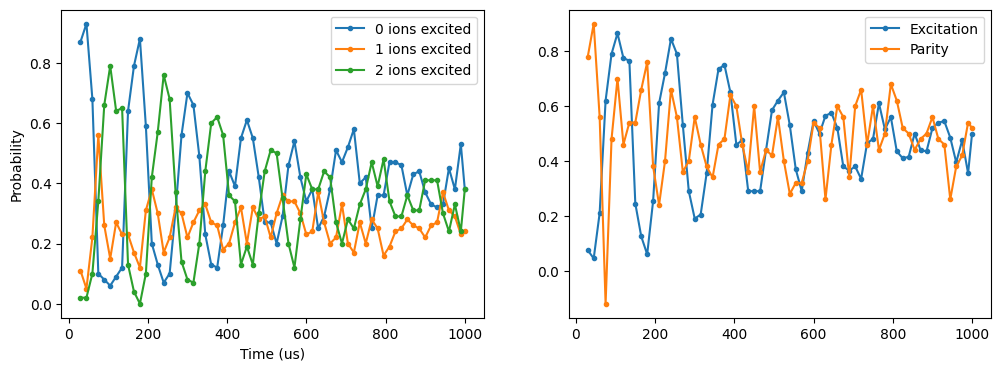

In [35]:
(fig, ax) = plt.subplots(1, 2, figsize=(12, 4))

N_ions = 2

for i in range(N_ions+1):
    y_i = y[:, i]
    ax[0].plot(x, y_i, '.-', label='{} ions excited'.format(i))
ax[0].set_xlabel('Time (us)')
ax[0].set_ylabel('Probability')
ax[0].legend()

excitation = 0.5*y[:, 1] + y[:, 2]
parity = y[:, 0] + y[:, 2] - y[:, 1]
ax[1].plot(x, excitation, '.-', label='Excitation')
ax[1].plot(x, parity, '.-', label='Parity')
ax[1].legend()

plt.show()

## `get_data_directory`

Returns the directory where a dataset is saved.

In [36]:
ldt.get_data_directory('20230217', '1511_29')

'/home/space-time/LabRAD/data/Experiments.dir/20230217.dir/Ramsey.dir/1511_29.dir/'

## `get_hist`

Your LabRAD setup may be configured to save histograms as data is saved. This doesn't contain any more information than the raw data counts in principle, but it simply takes a few data points' worth of photon counts and decides how to bin them so that it can be directly plotted as a histogram.

Example of how the data is stored:

In [37]:
import os
directory = ldt.get_data_directory('20230217', '1511_29')
sorted(os.listdir(directory))

['00001 - 1511_29.csv',
 '00001 - 1511_29.ini',
 '00001 - 1511_29.pickle',
 '00002 - Readouts.csv',
 '00002 - Readouts.ini',
 '00003 - Histogram.csv',
 '00003 - Histogram.ini',
 '00004 - Histogram.csv',
 '00004 - Histogram.ini',
 '00005 - Histogram.csv',
 '00005 - Histogram.ini',
 '00006 - Histogram.csv',
 '00006 - Histogram.ini',
 '00007 - Histogram.csv',
 '00007 - Histogram.ini',
 '00008 - Histogram.csv',
 '00008 - Histogram.ini',
 '00009 - Histogram.csv',
 '00009 - Histogram.ini',
 '00010 - Histogram.csv',
 '00010 - Histogram.ini',
 '00011 - Histogram.csv',
 '00011 - Histogram.ini',
 '00012 - Histogram.csv',
 '00012 - Histogram.ini',
 '00013 - Histogram.csv',
 '00013 - Histogram.ini',
 '00014 - Histogram.csv',
 '00014 - Histogram.ini',
 '00015 - Histogram.csv',
 '00015 - Histogram.ini',
 'session.ini']

A bunch of histograms have been created. Use get_hist to extract the histogram data in one of them. You must pass in a third argument to specify the number of the histogram whose data you want to extract, specified by that leading number in the filename.

The histogram data in this form can be plotted directly using the matplotlib function `bar`.

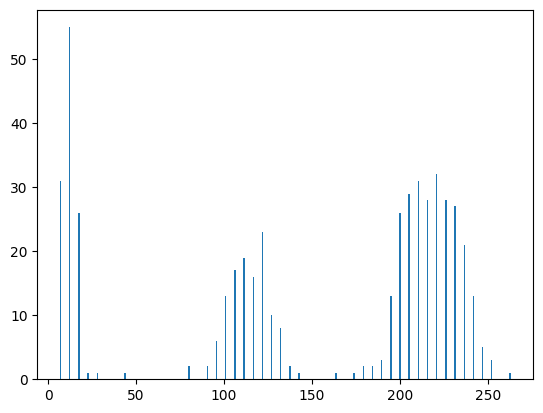

In [38]:
(bins, instances) = ldt.get_hist('20230217', '1511_29', 3)
plt.bar(bins, instances)
plt.show()

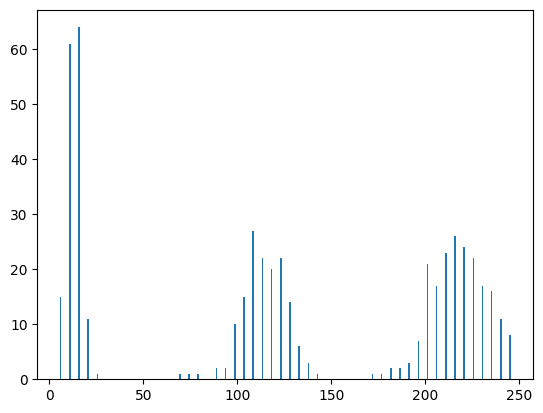

In [39]:
(bins, instances) = ldt.get_hist('20230217', '1511_29', 15)
plt.bar(bins, instances)
plt.show()

If you try to access a histogram number that is out of the bounds, an error will be thrown:

In [40]:
(bins, instances) = ldt.get_hist('20230217', '1511_29', 16)

ValueError: Histogram number must be between 3 and 15.

If you want all the photon count data for an entire scan, it's probably best to start from `get_photon_counts` and aggregate the raw photon count data rather than starting from `get_hist`.

## `get_pmt_counts`

All raw continuous PMT count time-series data is stored in its own files with a simple naming structure that increments in number every time a new dataset is started. Using `get_pmt_counts` to get that raw time-series data for one of those datasets.

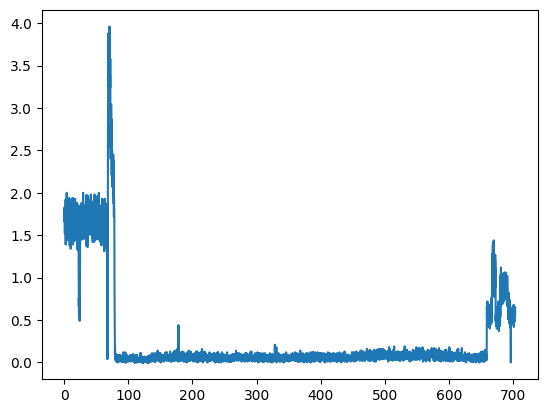

In [41]:
(x, y) = ldt.get_pmt_counts(400)
plt.plot(x, y)
plt.show()